In [161]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
import matplotlib.pyplot as plt


In [162]:
path_to_project = "~/Downloads/AkeFiles/Files/project_ver2/new_version/ProteinLigandPredictor/structured"

# path to results of simulations (realValues)
rV_file_name = "list_of_ligand_out_for_Ragav.txt"
# path to predictions of 39 complexes with 10 poses (predictedValues)
pV_file_name = "logs/predictions_on_test_cases/390_predictions.csv"
# data for affinities of complexes (affinityBank)
aB_file_name = "formatted_binding.csv"

In [163]:
rV_file_path = (f"{path_to_project}/{rV_file_name}")
pV_file_path = (f"{path_to_project}/{pV_file_name}")
aB_file_path = (f"{path_to_project}/{aB_file_name}")

rV = pd.read_csv(rV_file_path, sep = "\t", names = ["rec","lig","dock","rmsd","pose","score"])
# Deleting the first row with titles
rV.drop(0, axis = 0, inplace = True)

pV = pd.read_csv(pV_file_path)
# Deleting the Unnamed column
pV.drop(["Unnamed: 0"], axis = 1, inplace = True)

aB = pd.read_csv(aB_file_path)
aB.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [39]:
rV.head()

,rec,lig,dock,rmsd,pose,score
1,1rv1,1rv1,glide,7.16,4,-3.28
2,1rv1,1rv1,glide,7.62,6,-3.28
3,1rv1,1rv1,glide,8.64,10,-2.48
4,1rv1,1rv1,gold,6.71,3,56.04
5,1rv1,1rv1,gold,7.15,2,56.3


In [40]:
pV.head()

,predictions,data_codes
0,0.102954,1rv1_1
1,2.118930,1rv1_10
2,1.138494,1rv1_2
3,0.336687,1rv1_3
4,1.803915,1rv1_4


In [51]:
# The names of unique complex names
complex_list = list(rV['rec'].unique())
# Makking the code names uppercase for comparsion facilitation
complex_list = list(map(lambda x: x.upper(), complex_list))
len(complex_list)

39

In [784]:
from collections import defaultdict

class FormatOptions:
    '''Class works only 
    for specific data files
    '''
    
    @staticmethod
    def find_best_poses(data, data_code_key = "data_codes", affinity_key = "predictions", haspose = False):
        """Finds the best pose of each complex

        param data: the DataFrame of complexes
        param data_code_key: the name of the key for the code 
        param affinity_key: the name of the key for the affinity value

        return best_pose: the dict containing the key as a code and a value as a tuple of best pose
        """

        best_pose = defaultdict(list)

        for index, row in data.iterrows():
            compaired_value = row[affinity_key] if isinstance(row[affinity_key], float) else float(row[affinity_key])

            if not haspose:
                best_pose[row[data_code_key][:4]] = (compaired_value, row[data_code_key])
            else:
                best_pose[row[data_code_key][:4]] = (compaired_value, f"{row[data_code_key]}_{(index % 10) + 1}")

        return best_pose 
    
    @staticmethod
    def attach_index_or_upper(data, key_name, make_upper = False):
        '''Attaches the real pose index to the code names
        or make upper case of the code names
        
        param key_name: the attribute name for the code name
        param make_upper: whether to make uppercase of the result code name
        '''
        for index,row in data.iterrows():
            if not make_upper:
                row[key_name] = f"{row[key_name]}_{(index % 9) + 2}"
            else:
                row[key_name] = row[key_name].upper()
                
    @staticmethod 
    def reset_index(data):
        data = data.reset_index()
        if "index" in data.columns:
            data = data.drop(["index"], axis = 1)
        return data
        

In [785]:
# Exclude some columns from the realValues table and change their names
formatted_rV = rV.copy()
formatted_rV["Representative"] = formatted_rV["rec"]
formatted_rV.drop(["rec", "lig"], axis = 1, inplace = True)

In [786]:
formatted_rV.head()

,dock,rmsd,pose,score,Representative
1,glide,7.16,4,-3.28,1rv1
2,glide,7.62,6,-3.28,1rv1
3,glide,8.64,10,-2.48,1rv1
4,gold,6.71,3,56.04,1rv1
5,gold,7.15,2,56.3,1rv1


In [787]:
# change index so that it starts from zero and delete old index column
formatted_rV = formatted_rV.reset_index()
formatted_rV.drop(["index"], axis = 1, inplace = True)

# put right pose indices
FormatOptions.attach_index_or_upper(formatted_rV, "Representative")

In [788]:
formatted_rV.head()

,dock,rmsd,pose,score,Representative
0,glide,7.16,4,-3.28,1rv1_2
1,glide,7.62,6,-3.28,1rv1_3
2,glide,8.64,10,-2.48,1rv1_4
3,gold,6.71,3,56.04,1rv1_5
4,gold,7.15,2,56.3,1rv1_6


In [959]:
# types of docking 
formatted_rV["dock"].unique()

array(['glide', 'gold', 'vina'], dtype=object)

In [960]:
FormatOptionsformatted_rV["dock"].describe()

NameError: name 'FormatOptionsformatted_rV' is not defined

In [1355]:
from scipy import stats 

def make_dock_split(formatted_data, split_by, compare = "rmsd", relative = "score", useless_columns = ["pose"]):
    # split realValues by different docking type
    splitted = defaultdict(dict)
    
    for item in formatted_data[split_by].unique():
        splitted[item] = formatted_data.loc[formatted_data[split_by].isin([item])]
    # delete the useless columns and reset the indices of splitted tables
    for key in splitted.keys():
        splitted[key] = splitted[key].reset_index()
        splitted[key][compare] = splitted[key][compare].astype(float)
        splitted[key][relative] = splitted[key][relative].astype(float)
        splitted[key].drop(["index"], axis = 1, inplace = True)
        
        intersections = np.intersect1d(useless_columns, splitted[key].columns)
        
        if len(intersections) > 0:
            splitted[key].drop(useless_columns, axis = 1, inplace = True)
    
    return splitted

def compute_correlations(splitted_dict, compare = ["score", "rmsd"]):
    correlation = defaultdict(dict)
    for key in splitted_dict.keys():
        correlation[key] = (splitted_dict[key].loc[:, compare]).corr()
    return correlation

def plot_correlations(correlation):
    
    if (len(correlation)) <= 1:
        fig, axarr = plt.subplots(figsize = (8, 8))
    else:
        fig, axarr = plt.subplots(len(correlation.keys()), 1, figsize = (8, 8))

    
    for index, key in enumerate(correlation.keys()):
        ax = sns.heatmap(
            data = correlation[key],
            ax = axarr[index] if (len(correlation)) > 1 else axarr,
            annot = True,
            cbar_kws = {'label':key}
        )
        ax.figure.axes[-1].yaxis.label.set_size(20)
        
def plot_scatters(splitted, x_key = 'score', y_key = 'rmsd', hue = "Representative", fig_width = 20, fig_height = 20, x_lim = 2,y_lim = 20):
    
    if len(splitted.keys()) == 1:
        fig, axarr = plt.subplots(figsize = (fig_width,fig_height))
    else:
        fig, axarr = plt.subplots(len(splitted.keys()), 1, figsize = (fig_width,fig_height))
    
    for index, key in enumerate(splitted.keys()):
        ax = sns.scatterplot(
            x = x_key, 
            y = y_key, 
            hue = hue,
            data = splitted[key],
            ax = axarr[index] if len(splitted.keys()) > 1 else axarr
        )
        ax.set_title(key)
        ax.set_xlim(0, x_lim)
        ax.set_ylim(0, y_lim)
        
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

    

In [962]:
format

<function format(value, format_spec='', /)>

In [963]:
splitted_rV = make_dock_split(formatted_rV, split_by = "dock", compare = "rmsd", relative = "score", useless_columns = ["pose"])

In [964]:
# for key in splitted_rV.keys():
#     print(key.upper())
#     print(splitted_rV[key]["score"].describe())
#     print("*"*40)
#     print(splitted_rV[key]["rmsd"].describe())
#     print()


In [1318]:
for key in splitted_rV.keys():
    print(splitted_rV[key].head())
    print("*"*40)

    dock  rmsd  score Representative
0  glide  7.16  -3.28         1rv1_2
1  glide  7.62  -3.28         1rv1_3
2  glide  8.64  -2.48         1rv1_4
3  glide  0.42  -6.91         1t4e_2
4  glide  4.97  -4.91         1t4e_3
****************************************
   dock  rmsd  score Representative
0  gold  6.71  56.04         1rv1_5
1  gold  7.15  56.30         1rv1_6
2  gold  8.90  49.49         1rv1_7
3  gold  1.00  63.22         1t4e_5
4  gold  1.17  62.18         1t4e_6
****************************************
   dock  rmsd  score Representative
0  vina  0.38   -8.1         1rv1_8
1  vina  7.50   -5.9         1rv1_9
2  vina  8.47   -6.1        1rv1_10
3  vina  0.77   -8.5         1t4e_8
4  vina  4.67   -6.9         1t4e_9
****************************************


In [1319]:
correlation_rV = compute_correlations(splitted_rV,compare = ["score", "rmsd"])

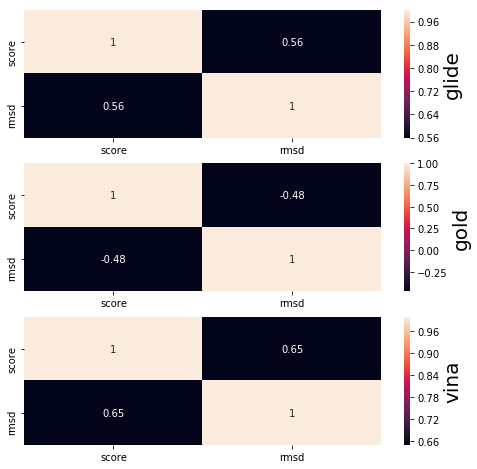

In [1320]:
plot_correlations(correlation_rV)

In [968]:
# Encode the codes with poses to just the codes
def to_code(row):
    row["Representative"] = row["Representative"][:4].upper()
    return row

'''
    Plotting scatters
    rmsd versus real values 
    for each docking type 
'''
rmsd_rV_dock = splitted_rV.copy()

for key in rmsd_rV_dock.keys():
    rmsd_rV_dock[key] = rmsd_rV_dock[key].apply(to_code, axis = 1)


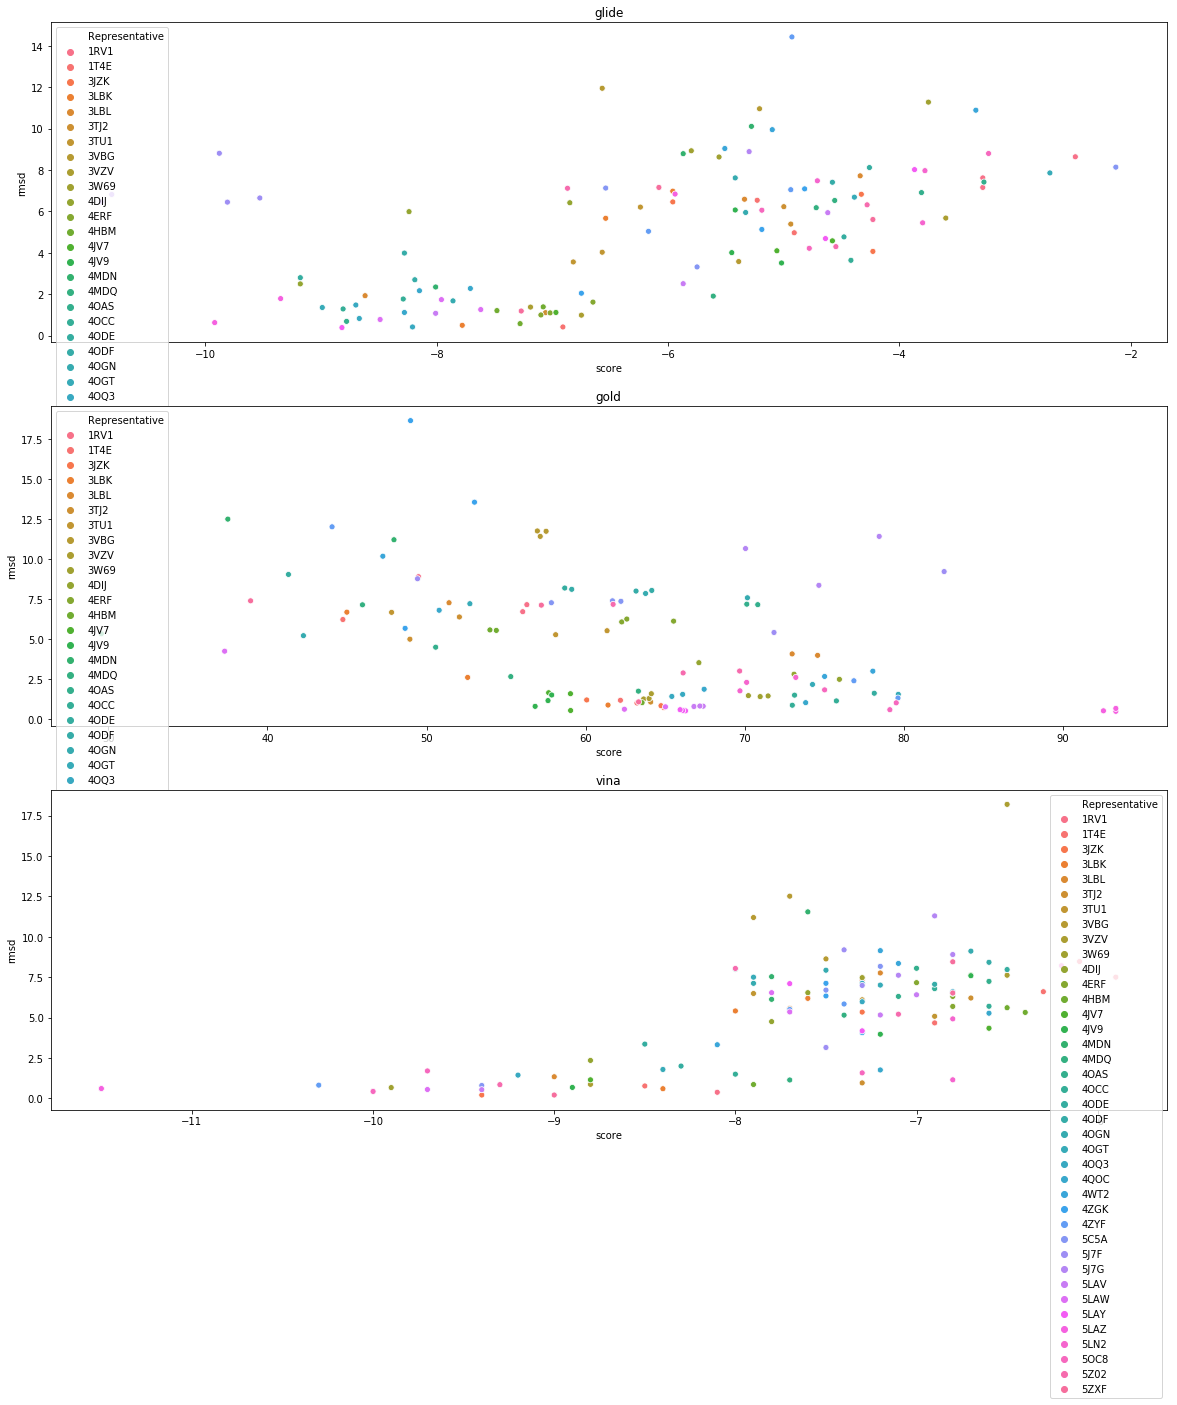

In [969]:
plot_scatters(rmsd_rV_dock, fig_height = 20, fig_width = 20)

In [799]:
formatted_pV = pV.copy()
formatted_pV["Representative"] = formatted_pV["data_codes"]

if "data_codes" in formatted_pV.columns:
    formatted_pV.drop(["data_codes"], axis = 1, inplace = True)

In [800]:
formatted_pV.shape

(390, 2)

In [801]:
formatted_rV.shape

(351, 5)

In [802]:
# Merge in relative to realValues (their shape is less) by the common column Representative
merged_real_predicted = pd.merge(formatted_rV, formatted_pV, on = "Representative")

In [803]:
rmsd_rV_dock = splitted_rV.copy()

for key in rmsd_rV_dock.keys():
    rmsd_rV_dock[key] = rmsd_rV_dock[key].apply(to_code, axis = 1)print(merged_real_predicted.head())
print("*"*40)
print(formatted_rV.head())
print("*"*40)
print(formatted_pV.head())

    dock  rmsd pose  score Representative  predictions
0  glide  7.16    4  -3.28         1rv1_2     1.138494
1  glide  7.62    6  -3.28         1rv1_3     0.336687
2  glide  8.64   10  -2.48         1rv1_4     1.803915
3   gold  6.71    3  56.04         1rv1_5     0.437793
4   gold  7.15    2   56.3         1rv1_6     0.285932
****************************************
    dock  rmsd pose  score Representative
0  glide  7.16    4  -3.28         1rv1_2
1  glide  7.62    6  -3.28         1rv1_3
2  glide  8.64   10  -2.48         1rv1_4
3   gold  6.71    3  56.04         1rv1_5
4   gold  7.15    2   56.3         1rv1_6
****************************************
   predictions Representative
0     0.102954         1rv1_1
1     2.118930        1rv1_10
2     1.138494         1rv1_2
3     0.336687         1rv1_3
4     1.803915         1rv1_4


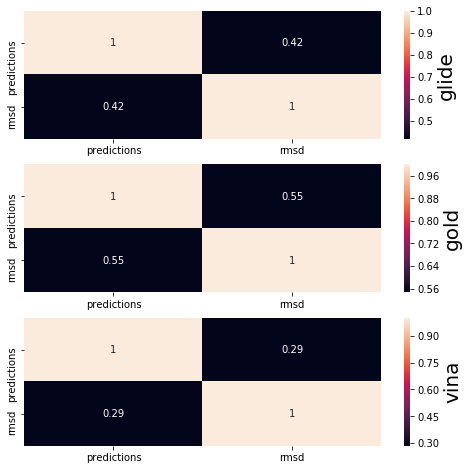

In [842]:
splitted_pV = make_dock_split(merged_real_predicted, split_by = "dock", compare = "rmsd", relative = "predictions",useless_columns = ["pose","score"])
correlation_pV = compute_correlations(splitted_pV,compare = ["predictions", "rmsd"])
plot_correlations(correlation_pV)

In [989]:
'''
    Plotting scatters
    rmsd versus predicted values 
    for each docking type 
'''

rmsd_pV_dock = splitted_pV.copy()

for key in rmsd_pV_dock.keys():
    rmsd_pV_dock[key] = rmsd_pV_dock[key].apply(to_code, axis = 1)


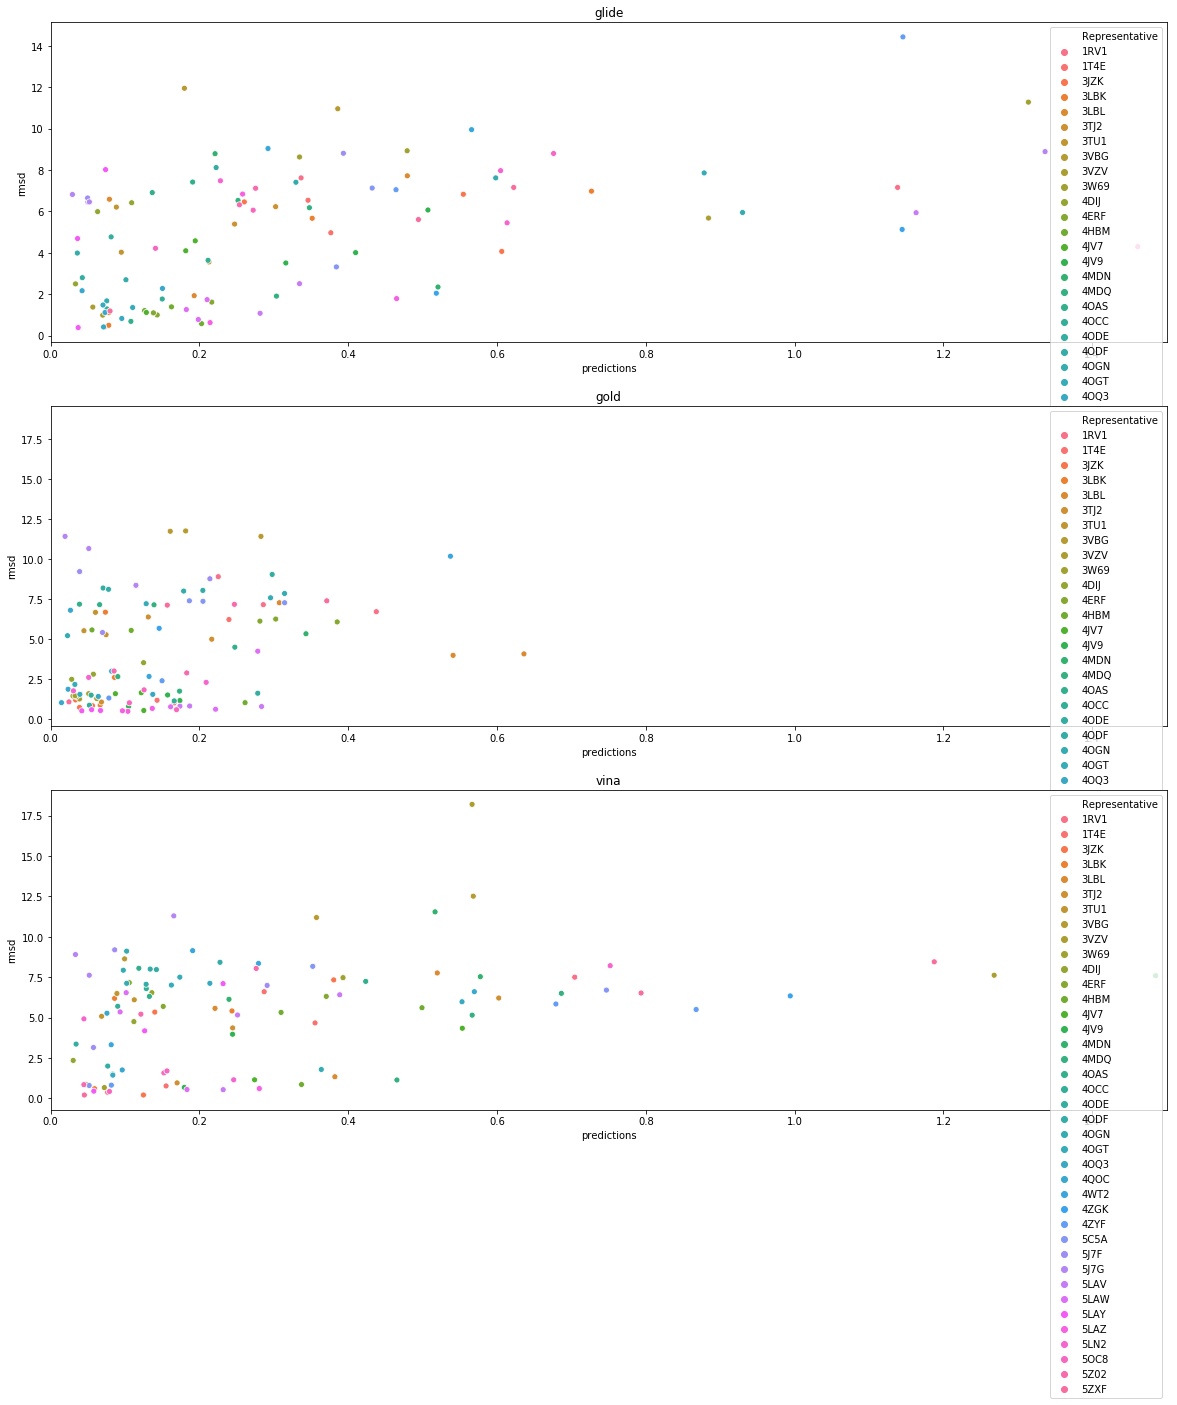

In [998]:
plot_scatters(rmsd_pV_dock, x_key = 'predictions',fig_height = 20, fig_width = 20, x_lim = 1.5)

In [973]:
print(rmsd_pV_dock["vina"].head(5))

'''
    Creating the table of rmsd versus predictions
    also counting the tenth pose for prediction 
    and setting rmsd for that pose as 0.1
'''
pass

   dock  rmsd Representative  predictions
0  vina  0.38           1RV1     7.115286
1  vina  7.50           1RV1     6.152136
2  vina  8.47           1RV1     5.673883
3  vina  0.77           1T4E     6.808959
4  vina  4.67           1T4E     6.449193


In [1072]:
merged_rmsd_predictions = pd.merge(formatted_rV, formatted_pV,how = "outer", on = "Representative")

In [1073]:
useless_columns = ["pose","score"]

intersections = np.intersect1d(useless_columns, merged_rmsd_predictions.columns)

if len(intersections) == len(useless_columns):
    merged_rmsd_predictions.drop(useless_columns, axis = 1, inplace = True)

In [1076]:
merged_rmsd_predictions["rmsd"].fillna(0.1, inplace = True)
merged_rmsd_predictions["dock"].fillna("Experimental Value", inplace = True)

In [1077]:
merged_rmsd_predictions[380:390]

,dock,rmsd,Representative,predictions
380,Experimental Value,0.1,5j7f_1,0.222635
381,Experimental Value,0.1,5j7g_1,0.019783
382,Experimental Value,0.1,5lav_1,0.226968
383,Experimental Value,0.1,5law_1,0.159922
384,Experimental Value,0.1,5lay_1,0.032492
385,Experimental Value,0.1,5laz_1,0.443592
386,Experimental Value,0.1,5ln2_1,0.159485
387,Experimental Value,0.1,5oc8_1,0.083629
388,Experimental Value,0.1,5z02_1,0.037828
389,Experimental Value,0.1,5zxf_1,0.059447


In [1078]:
# Sort by Representative, so that the old order will preserve
merged_rmsd_predictions.sort_values(by = ["Representative"], inplace = True)

In [1079]:
merged_rmsd_predictions.head()

,dock,rmsd,Representative,predictions
351,Experimental Value,0.1,1rv1_1,0.102954
8,vina,8.47,1rv1_10,2.118930
0,glide,7.16,1rv1_2,1.138494
1,glide,7.62,1rv1_3,0.336687
2,glide,8.64,1rv1_4,1.803915


In [1080]:
merged_rmsd_predictions = FormatOptions.reset_index(merged_rmsd_predictions)

In [1081]:
'''
    rmsd versus prediction values,
    the pose zero indicates the rmsd 0.1 
    since we totally know that this in this 
    pose, the ligand is a binder

'''

merged_rmsd_predictions.head()

,dock,rmsd,Representative,predictions
0,Experimental Value,0.1,1rv1_1,0.102954
1,vina,8.47,1rv1_10,2.118930
2,glide,7.16,1rv1_2,1.138494
3,glide,7.62,1rv1_3,0.336687
4,glide,8.64,1rv1_4,1.803915


In [1082]:
# The intersections of complex_list with affinity bank
intersections = (aB.loc[aB["Representative"].isin(complex_list)])
intersections_set = list(intersections["Representative"].unique())

In [1130]:
 METRIC_CONVERT = {
        'mM':10**-3,
        'uM':10**-6,
        'pM':10**-12,
        'nM':10**-9,
        'fM':10**-15,
        'M':10**0
    }

def convert_to_log_10(row):
    row["Num"] *= METRIC_CONVERT[row["Unit"]]
    row["Num"] = (-1) * np.log10(row["Num"])
    return row
    
aB_intersected = aB.loc[aB["Representative"].isin(complex_list)]
print(aB_intersected.head())
aB_intersected = aB_intersected.apply(convert_to_log_10, axis = 1)
aB_intersected.head()

     Representative Metric    Num Unit
3057           4OAS     Kd  0.045   nM
3058           3JZK   ic50  1.230   uM
3059           4JV7   ic50  1.000   uM
3061           5LN2   ic50  0.130   nM
3063           4ZYF     Ki  1.300   nM


,Representative,Metric,Num,Unit
3057,4OAS,Kd,10.346787,nM
3058,3JZK,ic50,5.910095,uM
3059,4JV7,ic50,6.000000,uM
3061,5LN2,ic50,9.886057,nM
3063,4ZYF,Ki,8.886057,nM


In [1141]:
# predictions of diferent poses versus one real affinity from affinity bank
p_v_r = merged_rmsd_predictions.copy()
# Add the column pose for easing the merging process
p_v_r["pose"] = p_v_r["Representative"]

In [1143]:
# changing pose to numeric
def attach_pose_index(row):
    try:
        pose_index = int(row["pose"][-2:])
    except:
        pose_index = int(row["pose"][-1:])
    row["pose"] = pose_index
    row["Representative"] = row["Representative"][:4].upper()
    
    return row

# change from mol to -log10, counting the fact that 
# predictions are given in micromol
def convert_to_log_10(row):
    row["predictions"] /= 10**6
    row["predictions"] = (-1)*np.log10(row["predictions"])
    return row

mappings = [attach_pose_index,convert_to_log_10]


In [1086]:
for mapping in mappings:
    p_v_r = p_v_r.apply(mapping, axis = 1)

In [1087]:
# if "rmsd" in p_v_r.columns:
#     p_v_r.drop(["rmsd"], axis = 1, inplace = True)

In [1088]:
# Since not all complexes have affinities from the affinity bank
p_v_r = p_v_r.loc[p_v_r["Representative"].isin(intersections_set)]
p_v_r.shape

(240, 5)

In [1089]:
merged_p_v_r = pd.merge(p_v_r, aB_intersected, how = "outer", on = "Representative")

In [1090]:
merged_p_v_r.shape

(240, 8)

In [1091]:
'''
    unique pdb codes in the sorted order 
'''

keys = merged_p_v_r["Representative"].unique()

In [1092]:
# splitted by each complex, so each key contains small dataframe
splitted_by_repr = make_dock_split(merged_p_v_r, split_by = "Representative", compare = "predictions", relative = "Num", useless_columns = ["Unit"])

In [1093]:
rv = splitted_by_repr["4OAS"]
rv.head(10)
merged_p_v_r.loc[merged_p_v_r["Representative"] == "4OAS"]


,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
120,Experimental Value,0.1,4OAS,7.757072,1,Kd,10.346787,nM
121,vina,8.05,4OAS,6.925758,10,Kd,10.346787,nM
122,glide,0.69,4OAS,6.966703,2,Kd,10.346787,nM
123,glide,6.91,4OAS,6.864332,3,Kd,10.346787,nM
124,glide,7.42,4OAS,6.719129,4,Kd,10.346787,nM
125,gold,4.49,4OAS,6.606125,5,Kd,10.346787,nM
126,gold,7.15,4OAS,7.181050,6,Kd,10.346787,nM
127,gold,7.18,4OAS,7.410734,7,Kd,10.346787,nM
128,vina,6.31,4OAS,6.876759,8,Kd,10.346787,nM
129,vina,7.24,4OAS,6.373094,9,Kd,10.346787,nM


In [1094]:
import h5py

"""
    Reading the training set to get to know 
    which of the 24 complexes were used 
    for the training process
"""
path_to_chimera = "/home/mussaa/Downloads/AkeFiles/Files/project/Sipga_project/chimera/"
path_to_preprocessed_data = f"{path_to_chimera}/preprocessed_data"
file_training = h5py.File(f"{path_to_preprocessed_data}/training.hdf", 'r')
file_general_set = h5py.File(f"{path_to_preprocessed_data}/general_set.hdf", 'r')



In [1095]:
'''
    Same pdb 24 codes but with lower case
'''

lower_keys = keys.copy()
index = 0
while index < len(lower_keys):
    lower_keys[index] =lower_keys[index].lower()
    index += 1


In [1096]:
used_for_training = set(file_training.keys()).intersection(set(lower_keys))

In [1097]:
'''
    The complexes from the 24 ones that were used 
    during the training of the model 
'''

len(used_for_training)

13

In [1098]:
used_for_training

{'1rv1',
 '3jzk',
 '3lbl',
 '3tu1',
 '3w69',
 '4dij',
 '4jv7',
 '4jv9',
 '4occ',
 '4ode',
 '4ogt',
 '4oq3',
 '4qoc'}

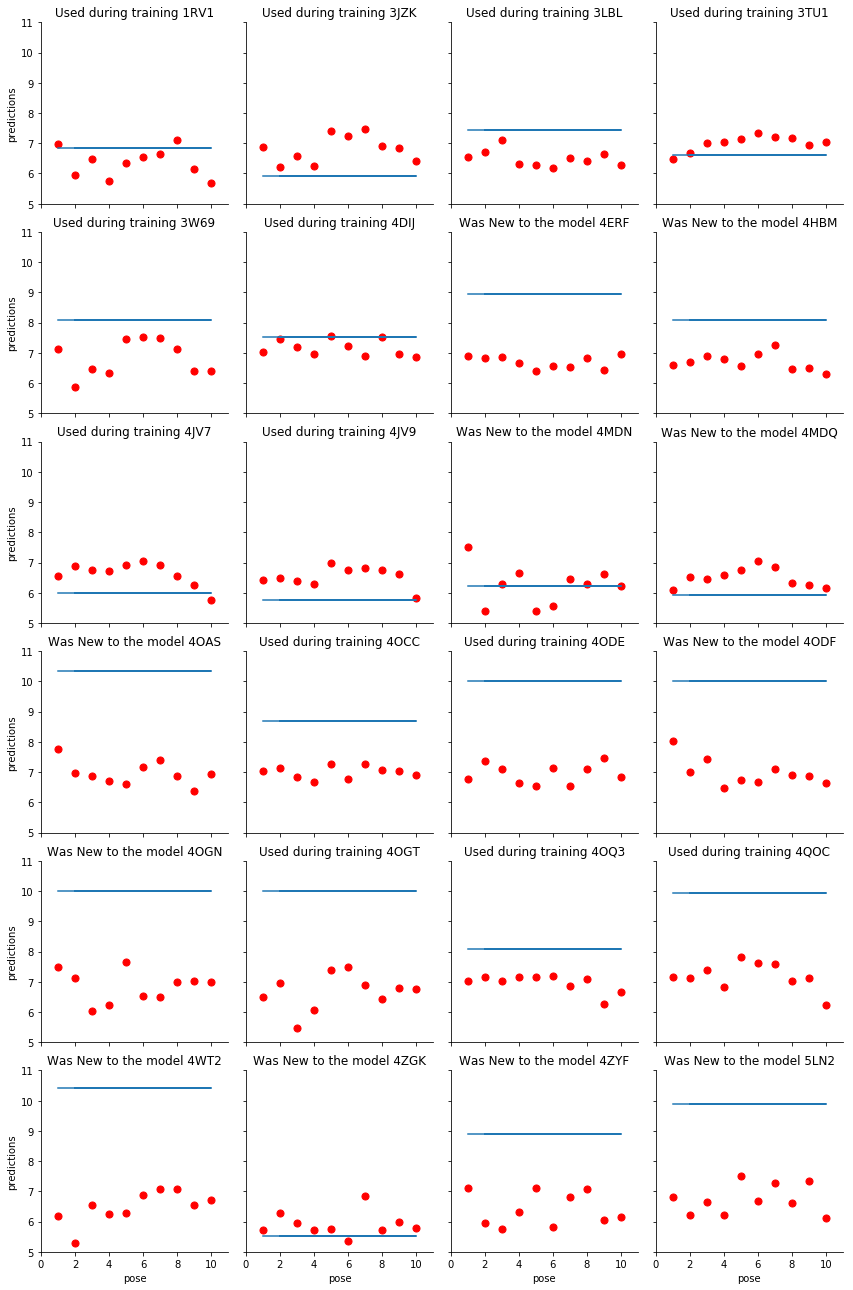

In [1099]:
'''
    col represents the third dimension, 
    
    graphics below demonstrate the 
    difference between
    the real affinty value 
    (the blue line) and the predictions 
    of each pose (read points)
'''

g = sns.FacetGrid(merged_p_v_r, col = 'Representative', margin_titles = True, col_wrap = 4)
g.map(plt.scatter, "pose", "predictions", color = "red", s = 50, lw = 1)
index = 0
for ax in g.axes.flat:
    ax.plot("pose", "Num", data = splitted_by_repr[keys[index]])
    
    if keys[index].lower() in used_for_training:
        ax.set_title(f"Used during training {keys[index]}")
    else:
        ax.set_title(f"Was New to the model {keys[index]}")
    index += 1
    

g.set(xlim = (0, 11),ylim = (5, 11))

In [1100]:
'''
    The 240 points in each scatter plot
    
    
    Below, the graphs (rmsd vs exp) and 
    (predicted vs exp) are plotted
'''
pass

In [1247]:
'''
    Converting back 
    to mol, assuming 
    that each value  
    is in micro mol
'''


def convert_to_mol(row):
    for numerical_col in ["Num", "predictions"]:
        row[numerical_col] = 1 / np.math.pow(10,row[numerical_col])
        row[numerical_col] = row[numerical_col] * 10**6   
    row["Unit"] = "uM"
    return row 


In [1248]:
merged_p_v_r_converted = merged_p_v_r.apply(convert_to_mol, axis = 1).copy()

In [1249]:
merged_p_v_r_converted.head(5)

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
0,Experimental Value,0.10,1RV1,0.102954,1,ic50,0.14,uM
1,vina,8.47,1RV1,2.118930,10,ic50,0.14,uM
2,glide,7.16,1RV1,1.138494,2,ic50,0.14,uM
3,glide,7.62,1RV1,0.336687,3,ic50,0.14,uM
4,glide,8.64,1RV1,1.803915,4,ic50,0.14,uM


In [1250]:
# sns.lmplot(x = "Num", y= 'rmsd', col = 'dock', data = merged_p_v_r_converted)
type(merged_p_v_r_converted)

pandas.core.frame.DataFrame

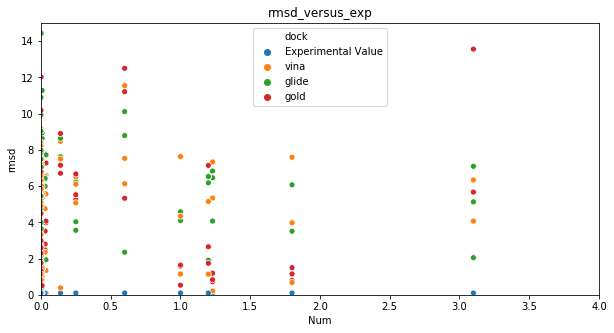

In [1346]:

one_to_one = {'rmsd_versus_exp':merged_p_v_r_converted}

plot_scatters(one_to_one, x_key = 'Num', y_key = 'rmsd', hue = "dock", fig_width = 10, fig_height = 5, x_lim =4, y_lim = 15)


/home/mussaa/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


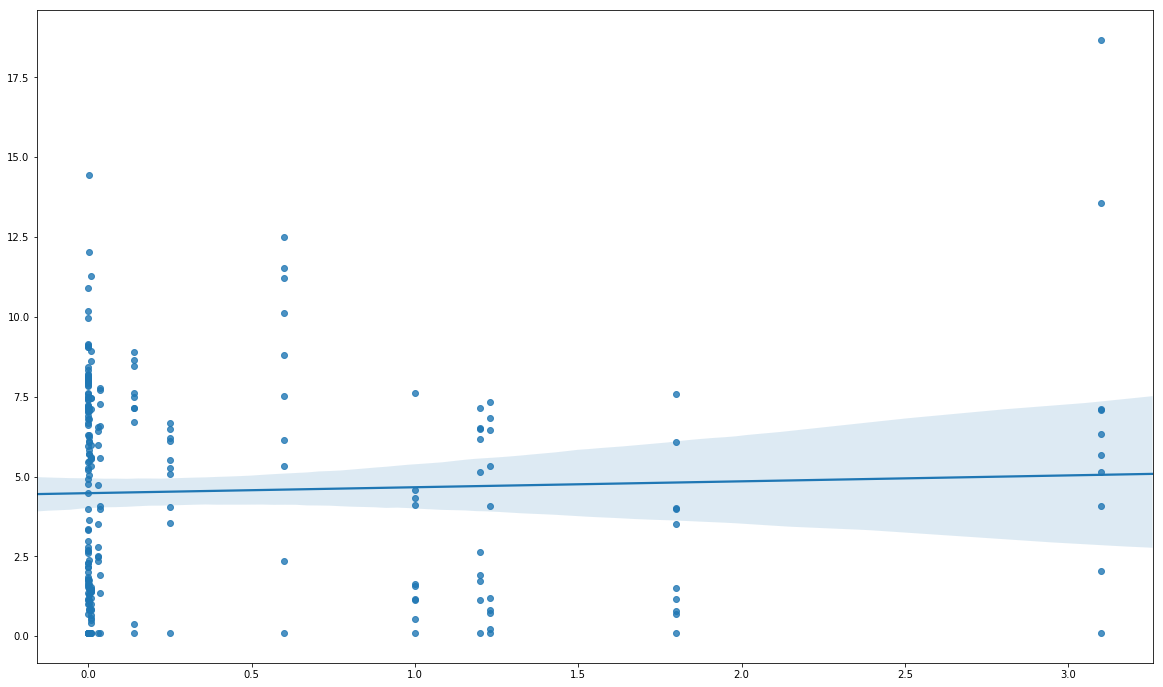

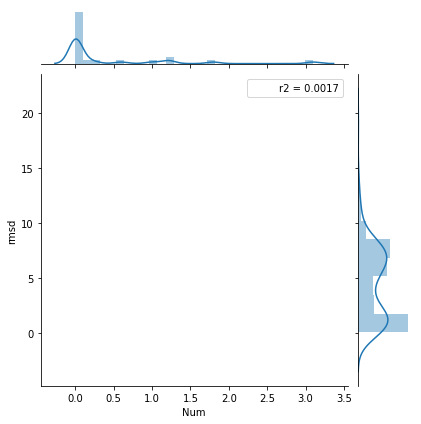

In [1353]:
fig, axarr = plt.subplots(figsize = (20, 12))
sns.jointplot(x = "Num", y = "rmsd", data = merged_p_v_r_converted, kind = "reg", stat_func = r2, ax = axarr)

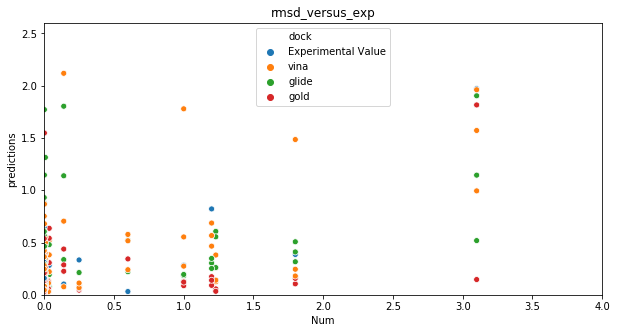

In [1348]:
plot_scatters(one_to_one, x_key = 'Num', y_key = 'predictions', hue = "dock", fig_width = 10, fig_height = 5, x_lim = 4, y_lim = 2.6)



/home/mussaa/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


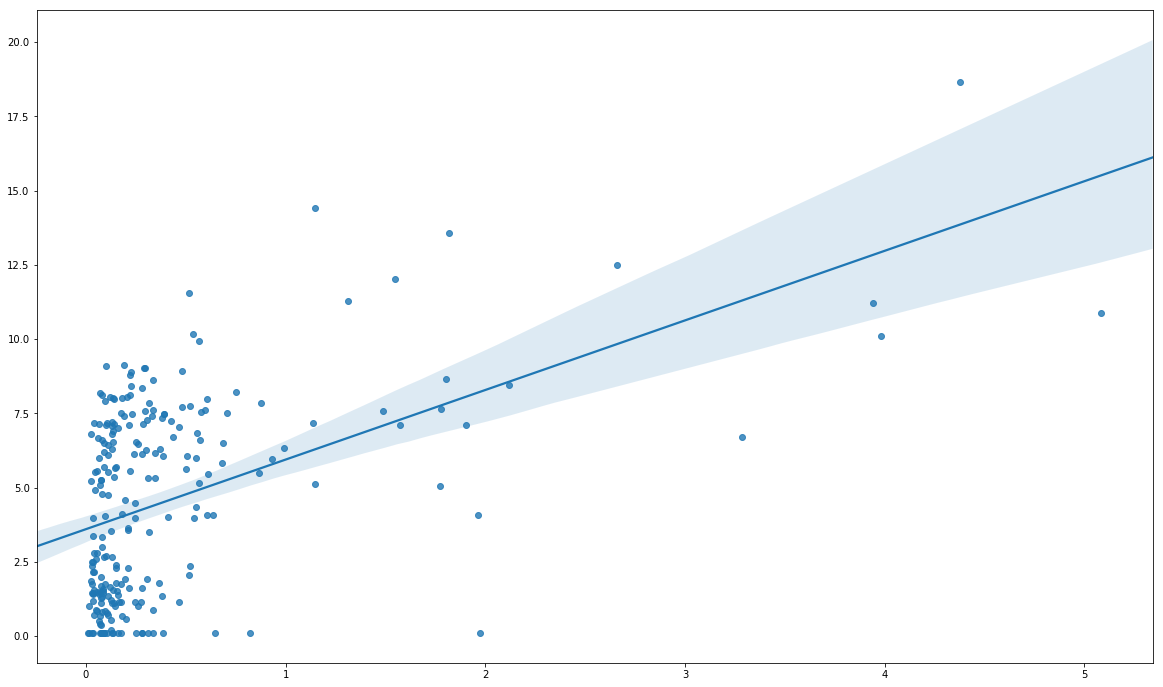

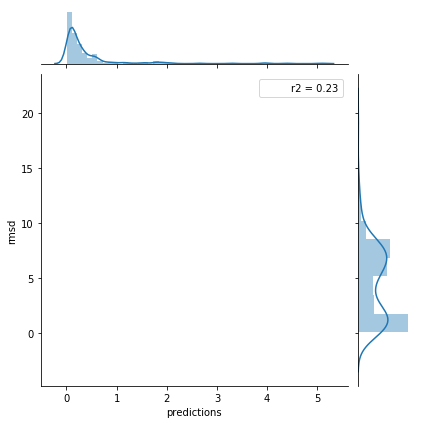

In [1352]:
fig, axarr = plt.subplots(figsize = (20, 12))
sns.jointplot(x = "predictions", y = "rmsd", data = merged_p_v_r_converted, kind = "reg", stat_func = r2, ax = axarr)

In [1271]:
merged_p_v_r_converted.head(11)

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
0,Experimental Value,0.10,1RV1,0.102954,1,ic50,0.14,uM
1,vina,8.47,1RV1,2.118930,10,ic50,0.14,uM
2,glide,7.16,1RV1,1.138494,2,ic50,0.14,uM
3,glide,7.62,1RV1,0.336687,3,ic50,0.14,uM
4,glide,8.64,1RV1,1.803915,4,ic50,0.14,uM
5,gold,6.71,1RV1,0.437793,5,ic50,0.14,uM
6,gold,7.15,1RV1,0.285932,6,ic50,0.14,uM
7,gold,8.90,1RV1,0.225383,7,ic50,0.14,uM
8,vina,0.38,1RV1,0.076686,8,ic50,0.14,uM
9,vina,7.50,1RV1,0.704472,9,ic50,0.14,uM


In [1334]:
"""
    The graphs of (rmsd_lowest, corresponding_prediction)
                  (corresponding_lowest, corresponding_rmsd)
    are plotted below

"""

# remove the artificial 0.1, since if we don't, all of the least rmsd will be 0.1
# real versus predictions versus experimental
r_pred_exp = merged_p_v_r_converted.drop(merged_p_v_r_converted.loc[merged_p_v_r_converted.dock == "Experimental Value"].index, axis = 0)

In [1299]:
r_pred_exp = FormatOptions.reset_index(r_pred_exp)

In [1301]:
r_pred_exp.head(10)

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
0,vina,8.47,1RV1,2.118930,10,ic50,0.14,uM
1,glide,7.16,1RV1,1.138494,2,ic50,0.14,uM
2,glide,7.62,1RV1,0.336687,3,ic50,0.14,uM
3,glide,8.64,1RV1,1.803915,4,ic50,0.14,uM
4,gold,6.71,1RV1,0.437793,5,ic50,0.14,uM
5,gold,7.15,1RV1,0.285932,6,ic50,0.14,uM
6,gold,8.90,1RV1,0.225383,7,ic50,0.14,uM
7,vina,0.38,1RV1,0.076686,8,ic50,0.14,uM
8,vina,7.50,1RV1,0.704472,9,ic50,0.14,uM
9,vina,7.33,3JZK,0.380558,10,ic50,1.23,uM


In [1308]:
min_rmsd_indices = r_pred_exp.groupby("Representative").rmsd.idxmin()

In [1311]:
# lowest rmsd versus predictions
r_pred = r_pred_exp.loc[min_rmsd_indices]

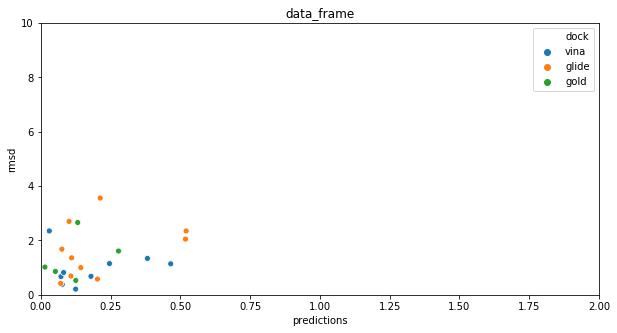

In [1315]:
one_to_one = {'data_frame':r_pred}
plot_scatters(one_to_one, x_key = 'predictions', y_key = 'rmsd', hue = "dock", fig_width = 10, fig_height = 5, x_lim = 2, y_lim = 10)


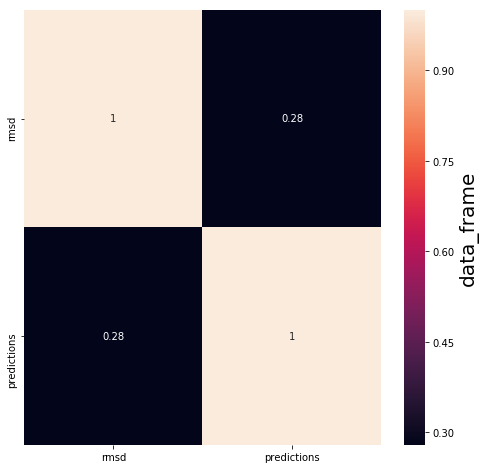

In [1325]:
r_pred_corr = compute_correlations(one_to_one, compare = ["rmsd", "predictions"])
plot_correlations(r_pred_corr)

In [1326]:
r_pred.head(10)

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
7,vina,0.38,1RV1,0.076686,8,ic50,0.1400,uM
16,vina,0.21,3JZK,0.124796,8,ic50,1.2300,uM
25,vina,1.34,3LBL,0.382131,8,Ki,0.0360,uM
28,glide,3.56,3TU1,0.212842,2,Ki,0.2500,uM
43,vina,0.67,3W69,0.072244,8,ic50,0.0083,uM
52,vina,2.35,4DIJ,0.030409,8,ic50,0.0300,uM
55,glide,1.00,4ERF,0.143330,2,ic50,0.0011,uM
64,glide,0.58,4HBM,0.202920,2,Kd,0.0082,uM
76,gold,0.53,4JV7,0.125320,5,ic50,1.0000,uM
88,vina,0.68,4JV9,0.179730,8,ic50,1.8000,uM


/home/mussaa/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


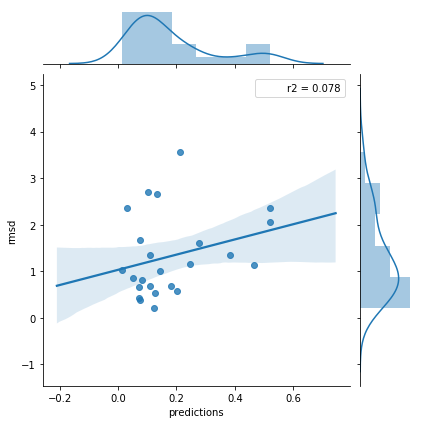

In [1358]:
'''
    The correlation between the lowest rmsd 
    and predictions 
    
'''


sns.jointplot(x = "predictions", y = "rmsd", data = r_pred, kind = "reg", stat_func = r2)

In [1335]:
r_pred_exp.head(10)

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
1,vina,8.47,1RV1,2.118930,10,ic50,0.14,uM
2,glide,7.16,1RV1,1.138494,2,ic50,0.14,uM
3,glide,7.62,1RV1,0.336687,3,ic50,0.14,uM
4,glide,8.64,1RV1,1.803915,4,ic50,0.14,uM
5,gold,6.71,1RV1,0.437793,5,ic50,0.14,uM
6,gold,7.15,1RV1,0.285932,6,ic50,0.14,uM
7,gold,8.90,1RV1,0.225383,7,ic50,0.14,uM
8,vina,0.38,1RV1,0.076686,8,ic50,0.14,uM
9,vina,7.50,1RV1,0.704472,9,ic50,0.14,uM
11,vina,7.33,3JZK,0.380558,10,ic50,1.23,uM


In [1339]:
r_pred_exp[10:20]

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
12,glide,4.07,3JZK,0.606427,2,ic50,1.230,uM
13,glide,6.46,3JZK,0.260396,3,ic50,1.230,uM
14,glide,6.83,3JZK,0.554779,4,ic50,1.230,uM
15,gold,0.72,3JZK,0.038935,5,ic50,1.230,uM
16,gold,0.83,3JZK,0.056304,6,ic50,1.230,uM
17,gold,1.19,3JZK,0.033615,7,ic50,1.230,uM
18,vina,0.21,3JZK,0.124796,8,ic50,1.230,uM
19,vina,5.34,3JZK,0.140060,9,ic50,1.230,uM
21,vina,7.76,3LBL,0.519760,10,Ki,0.036,uM
22,glide,1.93,3LBL,0.192990,2,Ki,0.036,uM


In [1337]:
min_prediction_indices = r_pred_exp.groupby("Representative").predictions.idxmin()
# corresponding rmsd versus lowest prediction
r_lowest_pred = r_pred_exp.loc[min_prediction_indices]

In [1338]:
r_lowest_pred.head(10)

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
8,vina,0.38,1RV1,0.076686,8,ic50,0.1400,uM
17,gold,1.19,3JZK,0.033615,7,ic50,1.2300,uM
23,glide,6.59,3LBL,0.079100,3,Ki,0.0360,uM
36,gold,5.52,3TU1,0.044847,6,Ki,0.2500,uM
46,gold,1.44,3W69,0.030097,6,ic50,0.0083,uM
55,gold,2.48,4DIJ,0.028396,5,ic50,0.0300,uM
61,vina,7.16,4ERF,0.105758,10,ic50,0.0011,uM
77,gold,5.57,4HBM,0.055641,7,Kd,0.0082,uM
86,gold,1.58,4JV7,0.087142,6,ic50,1.0000,uM
95,gold,0.79,4JV9,0.104899,5,ic50,1.8000,uM


/home/mussaa/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


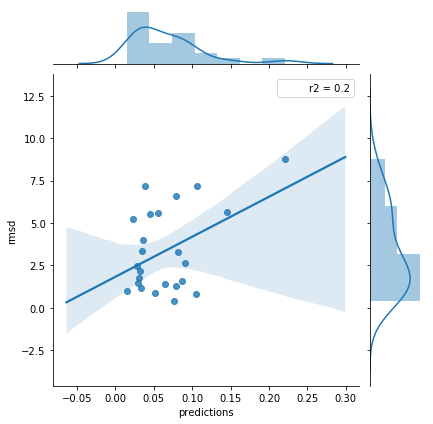

In [1357]:
sns.jointplot(x = "predictions", y = "rmsd", data = r_lowest_pred, kind = "reg", stat_func = r2)

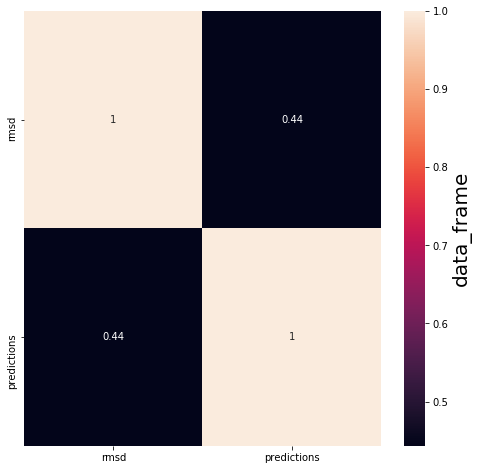

In [1356]:
one_to_one = {'data_frame':r_lowest_pred}
r_lowest_pred_corr = compute_correlations(one_to_one, compare = ["rmsd", "predictions"])
plot_correlations(r_lowest_pred_corr)

In [1354]:
r_pred_exp.head(10)

,dock,rmsd,Representative,predictions,pose,Metric,Num,Unit
1,vina,8.47,1RV1,2.118930,10,ic50,0.14,uM
2,glide,7.16,1RV1,1.138494,2,ic50,0.14,uM
3,glide,7.62,1RV1,0.336687,3,ic50,0.14,uM
4,glide,8.64,1RV1,1.803915,4,ic50,0.14,uM
5,gold,6.71,1RV1,0.437793,5,ic50,0.14,uM
6,gold,7.15,1RV1,0.285932,6,ic50,0.14,uM
7,gold,8.90,1RV1,0.225383,7,ic50,0.14,uM
8,vina,0.38,1RV1,0.076686,8,ic50,0.14,uM
9,vina,7.50,1RV1,0.704472,9,ic50,0.14,uM
11,vina,7.33,3JZK,0.380558,10,ic50,1.23,uM


In [1360]:
"""
    The graphs of (rmsd_lowest, experimental value)
                  (pred_lowest, experimental value)
    are plotted below

"""
pass

/home/mussaa/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


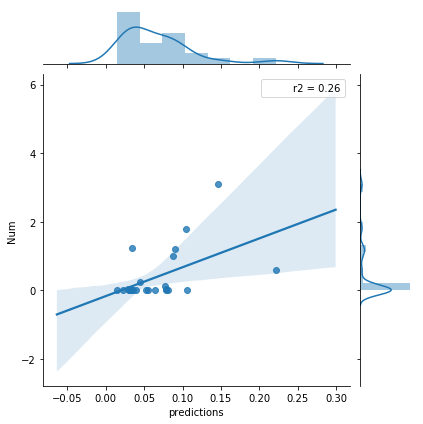

In [1362]:
sns.jointplot(x = "predictions", y = "Num", data = r_lowest_pred, kind = "reg", stat_func = r2)

/home/mussaa/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


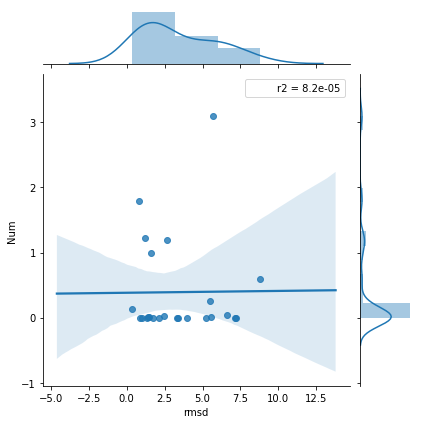

In [1363]:
sns.jointplot(x = "rmsd", y = "Num", data = r_lowest_pred, kind = "reg", stat_func = r2)